# Forecast Model Run Collections (FMRC) with a custom Xarray Index

There are many ways one might index weather forecast output. These different ways of constructing views of a forecast data are called "Forecast Model Run Collections" (FMRC).
- "Model Run" : a single model run.
- "Constant Offset" : all values for a given lead time.
- "Constant Forecast" : all forecasts for a given time in the future.
- "Best Estimate" : A best guess stitching together the analysis or initialization fields for past forecasts with the latest forecast.

For reference, see [this classic image](https://www.unidata.ucar.edu/presentations/caron/FmrcPoster.pdf).

Assume that a data cube has been constructed with `forecast_reference_time` (commonly `time`) and `forecast_period` (commonly `step` or `lead`) as dimensions.


Then the more complex indexing patterns --- "Constant Forecast" or "Best Estimate" --- are achievable with numpy-style vectorized indexing.
This notebook demonstrates all 4 "FMRC" indexing patterns with a custom Xarray index.


Some complexity arises from models like HRRR where not all runs are the same length (unlike GFS).
This complexity is handled by hardcoding in what data is available for each model: for example, with HRRR we know there are 49 `step`s available every 6 hours, and 19 `steps` otherwise.

In [3]:
from forecast_index import (
    BestEstimate,
    ConstantForecast,
    ConstantOffset,
    ForecastIndex,
    Model,
    ModelRun,
)

## Create an example data cube

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(keep_attrs=True)

ds = xr.Dataset(attrs={"description": "Example HRRR-like dataset"})
shape = {"x": 40, "time": 365*24, "step": 49}
ds["foo"] = (("x", "time", "step"), np.ones(tuple(shape.values())))
ds["time"] = (
    "time",
    pd.date_range("2023-01-01", freq="h", periods=shape["time"]),
    {"standard_name": "forecast_reference_time"},
)
ds["step"] = (
    "step",
    pd.to_timedelta(np.arange(0, 49), unit="hours"),
    {"standard_name": "forecast_period"},
)

In [5]:
ds.chunk(time=1, step=1)

<xarray.Dataset> Size: 6MB
Dimensions:  (x: 40, time: 365, step: 49)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2023-01-01 ... 2023-01-16T04:00:00
  * step     (step) timedelta64[ns] 392B 00:00:00 01:00:00 ... 2 days 00:00:00
Dimensions without coordinates: x
Data variables:
    foo      (x, time, step) float64 6MB dask.array<chunksize=(40, 1, 1), meta=np.ndarray>
Attributes:
    description:  Example HRRR-like dataset

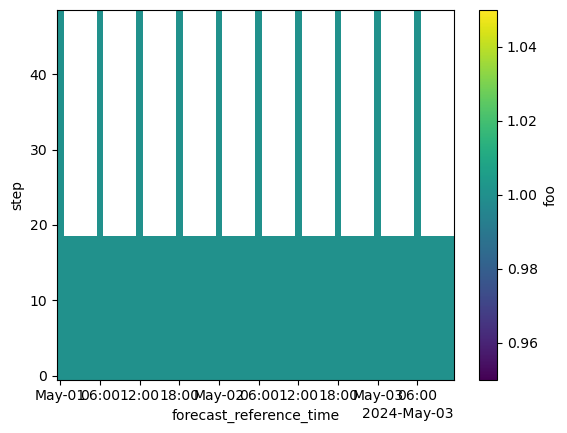

In [5]:
ds["foo"] = xr.where(
    ~((ds.time.dt.hour % 6 != 0) & (ds.step.dt.total_seconds() / 3600 > 18)),
    ds.foo,
    np.nan,
)
ds.foo.isel(x=20).drop_vars("step").plot(x="time")

In [6]:
ideal_ds = ds
ideal_ds

<xarray.Dataset> Size: 942kB
Dimensions:  (time: 60, step: 49, x: 40)
Coordinates:
  * time     (time) datetime64[ns] 480B 2024-05-01 ... 2024-05-03T11:00:00
  * step     (step) timedelta64[ns] 392B 00:00:00 01:00:00 ... 2 days 00:00:00
Dimensions without coordinates: x
Data variables:
    foo      (time, step, x) float64 941kB 1.0 1.0 1.0 1.0 ... nan nan nan nan
Attributes:
    description:  Example HRRR-like dataset

In [7]:
import arraylake as al

In [10]:
client = al.Client()
repo = client.get_repo("earthmover-demos/hrrr")
ds = repo.to_xarray("solar", chunks={})
ds

<xarray.Dataset> Size: 3TB
Dimensions:      (x: 1799, y: 1059, time: 1222, step: 49)
Coordinates:
    latitude     (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude    (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    spatial_ref  float64 8B ...
  * step         (step) timedelta64[ns] 392B 00:00:00 ... 2 days 00:00:00
  * time         (time) datetime64[ns] 10kB 2024-05-12T18:00:00 ... 2024-07-0...
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, time, step) float32 456GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    gust         (x, y, time, step) float32 456GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    prate        (x, y, time, step) float32 456GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    r2           (x, y, time, step) float32 456GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    t2m          (x, y, time, step) float32 456GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    tcc          (x, y, time, step) float32 456GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...

## Create a ForecastIndex

In [16]:
# Add a dummy variable to enable nice indexing syntax
# e.g. `.sel(forecast=ConstantForecast('2024-05-22'))`
ds.coords["forecast"] = 0

# set the new index
newds = (
    ds.isel(time=slice(-120, None))
    .drop_indexes(["time", "step"])
    .set_xindex(["time", "step", "forecast"], ForecastIndex, model=Model.HRRR)
)
newds

<xarray.Dataset> Size: 269GB
Dimensions:      (x: 1799, y: 1059, time: 120, step: 49)
Coordinates:
    latitude     (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude    (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    spatial_ref  float64 8B ...
  * time         (time) datetime64[ns] 960B 2024-06-27T16:00:00 ... 2024-07-0...
  * step         (step) timedelta64[ns] 392B 00:00:00 ... 2 days 00:00:00
  * forecast     int64 8B 0
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, time, step) float32 45GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    gust         (x, y, time, step) float32 45GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    prate        (x, y, time, step) float32 45GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    r2           (x, y, time, step) float32 45GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    t2m          (x, y, time, step) float32 45GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
    tcc          (x, y, time, step) float32 45GB dask.array<chunksize=(360, 120, 1, 19), meta=np.ndarray>
Indexes:
  ┌ time      ForecastIndex
  │ step
  └ forecast
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...

## "Standard" selection

In [5]:
newds.sel(time=slice("2024-05-03", None), step=slice("2h", "12h"))

<xarray.Dataset> Size: 42kB
Dimensions:   (time: 12, step: 11, x: 40)
Coordinates:
  * time      (time) datetime64[ns] 96B 2024-05-03 ... 2024-05-03T11:00:00
  * step      (step) timedelta64[ns] 88B 02:00:00 03:00:00 ... 11:00:00 12:00:00
  * forecast  int64 8B 0
Dimensions without coordinates: x
Data variables:
    foo       (time, step, x) float64 42kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Indexes:
  ┌ forecast  ForecastIndex
  │ time
  └ step
Attributes:
    description:  Example HRRR-like dataset

## FMRC indexing

For all cases, the index knows how to select values so there are no NaNs i.e. it only tries to pull out valid data! 
We've told it this is HRRR, and the HRRR output characteristics are hard-coded in the index. This could be refactored a little.

Other models, like GFS, don't require any configuration.


### `BestEstimate`

In [13]:
subset = newds.sel(forecast=BestEstimate())
# assert not subset.foo.isnull().any().item()
subset

<xarray.Dataset> Size: 57GB
Dimensions:      (x: 1799, y: 1059, valid_time: 1240)
Coordinates:
    latitude     (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude    (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    spatial_ref  float64 8B ...
    time         (valid_time) datetime64[ns] 10kB 2024-05-12T18:00:00 ... 202...
    step         (valid_time) timedelta64[ns] 10kB 00:00:00 ... 18:00:00
  * valid_time   (valid_time) datetime64[ns] 10kB 2024-05-12T18:00:00 ... 202...
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, valid_time) float32 9GB dask.array<chunksize=(360, 120, 1240), meta=np.ndarray>
    gust         (x, y, valid_time) float32 9GB dask.array<chunksize=(360, 120, 1240), meta=np.ndarray>
    prate        (x, y, valid_time) float32 9GB dask.array<chunksize=(360, 120, 1240), meta=np.ndarray>
    r2           (x, y, valid_time) float32 9GB dask.array<chunksize=(360, 120, 1240), meta=np.ndarray>
    t2m          (x, y, valid_time) float32 9GB dask.array<chunksize=(360, 120, 1240), meta=np.ndarray>
    tcc          (x, y, valid_time) float32 9GB dask.array<chunksize=(360, 120, 1240), meta=np.ndarray>
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...

### `ConstantForecast`

**TODO:** Adding a scalar `valid_time` for `ConstantForecast` triggers a bug.

In [31]:
subset = newds.sel(forecast=ConstantForecast("2024-06-29"))
# assert not subset.foo.isnull().any().item()
subset

<xarray.Dataset> Size: 899MB
Dimensions:      (x: 1799, y: 1059, time: 19)
Coordinates:
    latitude     (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude    (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    spatial_ref  float64 8B ...
  * time         (time) datetime64[ns] 152B 2024-06-28T06:00:00 ... 2024-06-29
    step         (time) timedelta64[ns] 152B 18:00:00 17:00:00 ... 00:00:00
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, time) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    gust         (x, y, time) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    prate        (x, y, time) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    r2           (x, y, time) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    t2m          (x, y, time) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    tcc          (x, y, time) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...

### `ConstantOffset`

In [21]:
subset = newds.sel(forecast=ConstantOffset("32h"))
# assert not subset.foo.isnull().any().item()
subset

<xarray.Dataset> Size: 945MB
Dimensions:      (x: 1799, y: 1059, time: 20)
Coordinates:
    latitude     (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude    (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    spatial_ref  float64 8B ...
  * time         (time) datetime64[ns] 160B 2024-06-27T18:00:00 ... 2024-07-0...
    step         timedelta64[ns] 8B 1 days 08:00:00
  * valid_time   (time) datetime64[ns] 160B 2024-06-29T02:00:00 ... 2024-07-0...
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, time) float32 152MB dask.array<chunksize=(360, 120, 1), meta=np.ndarray>
    gust         (x, y, time) float32 152MB dask.array<chunksize=(360, 120, 1), meta=np.ndarray>
    prate        (x, y, time) float32 152MB dask.array<chunksize=(360, 120, 1), meta=np.ndarray>
    r2           (x, y, time) float32 152MB dask.array<chunksize=(360, 120, 1), meta=np.ndarray>
    t2m          (x, y, time) float32 152MB dask.array<chunksize=(360, 120, 1), meta=np.ndarray>
    tcc          (x, y, time) float32 152MB dask.array<chunksize=(360, 120, 1), meta=np.ndarray>
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...

### `ModelRun`

In [30]:
subset = newds.sel(forecast=ModelRun("2024-06-30 03:00"))  # 19
assert subset.sizes["step"] == 19
subset

<xarray.Dataset> Size: 899MB
Dimensions:      (x: 1799, y: 1059, step: 19)
Coordinates:
    latitude     (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude    (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    spatial_ref  float64 8B ...
    time         datetime64[ns] 8B 2024-06-30T03:00:00
  * step         (step) timedelta64[ns] 152B 00:00:00 01:00:00 ... 18:00:00
  * valid_time   (step) datetime64[ns] 152B 2024-06-30T03:00:00 ... 2024-06-3...
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, step) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    gust         (x, y, step) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    prate        (x, y, step) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    r2           (x, y, step) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    t2m          (x, y, step) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    tcc          (x, y, step) float32 145MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...

In [29]:
subset = newds.sel(forecast=ModelRun("2024-06-30 06:00"))  # 49
assert subset.sizes["step"] == 49
subset

<xarray.Dataset> Size: 2GB
Dimensions:      (x: 1799, y: 1059, step: 49)
Coordinates:
    latitude     (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude    (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    spatial_ref  float64 8B ...
    time         datetime64[ns] 8B 2024-06-30T06:00:00
  * step         (step) timedelta64[ns] 392B 00:00:00 ... 2 days 00:00:00
  * valid_time   (step) datetime64[ns] 392B 2024-06-30T06:00:00 ... 2024-07-0...
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, step) float32 373MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    gust         (x, y, step) float32 373MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    prate        (x, y, step) float32 373MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    r2           (x, y, step) float32 373MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    t2m          (x, y, step) float32 373MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
    tcc          (x, y, step) float32 373MB dask.array<chunksize=(360, 120, 19), meta=np.ndarray>
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...